# Inputs

In [106]:
import os
import re

folder_name = '327/Pulse Calibration Redo'
file_names = [file_name for file_name in os.listdir(folder_name) if re.match(r'^\d+_\d+\.csv$', file_name)]

# Import packages

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
from scipy.stats import t
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
# %matplotlib widget

# Load data

In [108]:
# Read the data and pulse times from filenames
data = []
pulse_times = []
for file_name in file_names:
    # Assumes the file name format has the pulse time (in us) before 'us'
    pulse_time = int(file_name.split('/')[-1].split('_')[0])
    df = pd.read_csv(os.path.join(folder_name, file_name), header=None, names=['t', 'CH1', 'CH2'])
    df = df.dropna()
    df = df[df['t'] > 0.001]
    data.append(df)
    pulse_times.append(pulse_time)

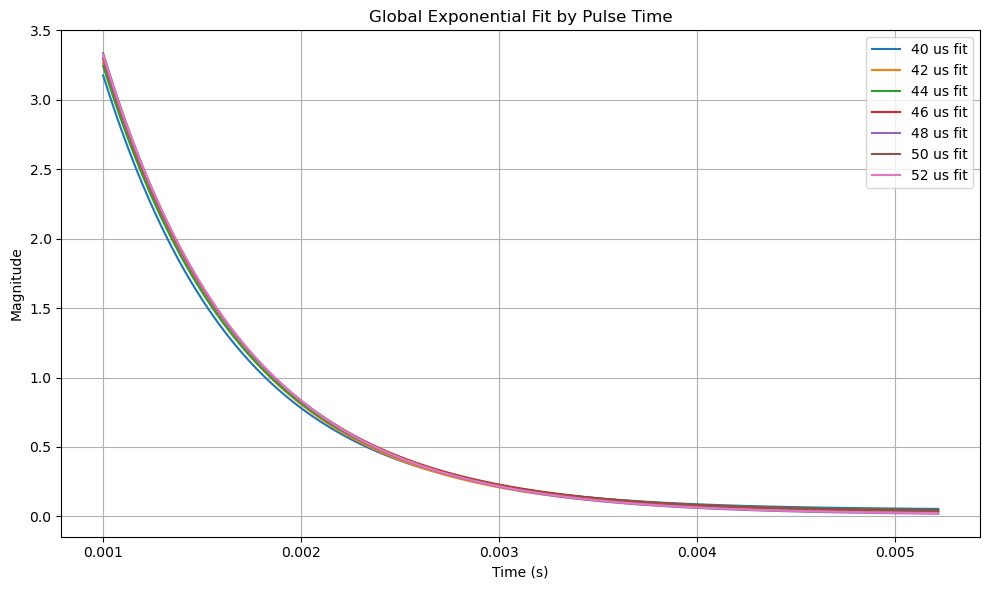

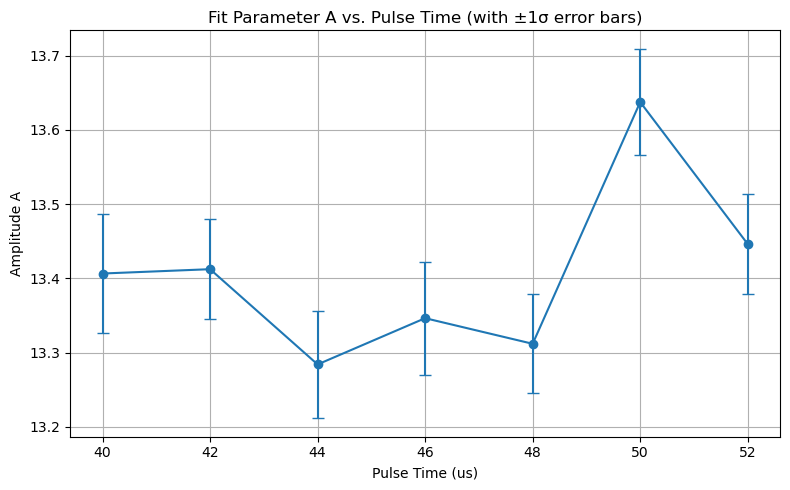

In [109]:
from collections import defaultdict

# Group magnitude traces by pulse time
grouped_mag_data = defaultdict(lambda: {'t': [], 'mag': []})

for df, pulse_time in zip(data, pulse_times):
    t = df['t'].values
    real = df['CH1'].values - df['CH1'].iloc[-1]
    imag = df['CH2'].values - df['CH2'].iloc[-1]
    mag = np.sqrt(real**2 + imag**2)

    grouped_mag_data[pulse_time]['t'].extend(t)
    grouped_mag_data[pulse_time]['mag'].extend(mag)

# Fit exponential to all data at each pulse time
global_fit_results = []

plt.figure(figsize=(10, 6))
for pulse_time, values in sorted(grouped_mag_data.items()):
    t_all = np.array(values['t'])
    mag_all = np.array(values['mag'])

    # Sort by time
    sort_idx = np.argsort(t_all)
    t_all = t_all[sort_idx]
    mag_all = mag_all[sort_idx]

    # Fit
    p0 = [mag_all[0], (t_all.max() - t_all.min()) / 2, np.min(mag_all)]
    try:
        popt, pcov = curve_fit(model_exp, t_all, mag_all, p0=p0)
        A_err = np.sqrt(np.diag(pcov))[0]
    except RuntimeError:
        popt = [np.nan, np.nan, np.nan]

    global_fit_results.append({
        'Pulse Time (us)': pulse_time,
        'A': popt[0],
        'T2* (us)': popt[1],
        'C': popt[2],
        'A_err': A_err
    })

    # Plot
    # plt.plot(t_all, mag_all, '.', alpha=0.3, label=f'{pulse_time} us data')
    if not np.isnan(popt).any():
        plt.plot(t_all, model_exp(t_all, *popt), '-', label=f'{pulse_time} us fit')

plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.title('Global Exponential Fit by Pulse Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(global_fit_results).sort_values('Pulse Time (us)')

plt.figure(figsize=(8, 5))
plt.errorbar(results_df['Pulse Time (us)'], results_df['A'], yerr=results_df['A_err'], fmt='o-', capsize=4)
plt.xlabel('Pulse Time (us)')
plt.ylabel('Amplitude A')
plt.title('Fit Parameter A vs. Pulse Time (with ±1σ error bars)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Fit envelope to decaying exponential

In [110]:
# Fit a decaying exponential to the envelope (no need for peak detection here)
# Model: A * exp(-t / T2*) + C
def model_exp(t, A, T2star, C):
    return A * np.exp(-t / T2star) + C

In [111]:
def fit_decay_with_envelope(df, channel='CH1', prominence=0.2, min_distance=100):
    t = df['t'].values
    signal_raw = df[channel].values
    
    # Compute the analytic signal using the Hilbert transform
    analytic_signal = hilbert(signal_raw)
    envelope = np.abs(analytic_signal)  # Extract the envelope (magnitude of analytic signal)
    
    # Optional: Apply smoothing to the envelope (e.g., Gaussian filter)
    envelope = gaussian_filter1d(envelope, sigma=5)  # Smoothing to suppress small oscillations
    
    # Initial guess for parameters A, T2*, and C (use the first value of the envelope as A, and its decay time)
    p0 = [envelope[0], (t.max() - t.min()) / 2.0, np.min(envelope)]
    popt, _ = curve_fit(model_exp, t, envelope, p0=p0)

    return popt, envelope

    Dataset  Pulse Time (us)  Real_T2star  Imag_T2star
0         1               42     0.000817     0.000654
1         2               40     0.000828     0.000656
2         3               44     0.000846     0.000654
3         4               40     0.000826     0.000649
4         5               42     0.000828     0.000653
5         6               42     0.000815     0.000645
6         7               40     0.000829     0.000650
7         8               46     0.000833     0.000645
8         9               40     0.000829     0.000650
9        10               42     0.000831     0.000655
10       11               46     0.000816     0.000654
11       12               44     0.000860     0.000659
12       13               44     0.000827     0.000649
13       14               46     0.000846     0.000652
14       15               42     0.000821     0.000649
15       16               40     0.000833     0.000660
16       17               46     0.000840     0.000648
17       1

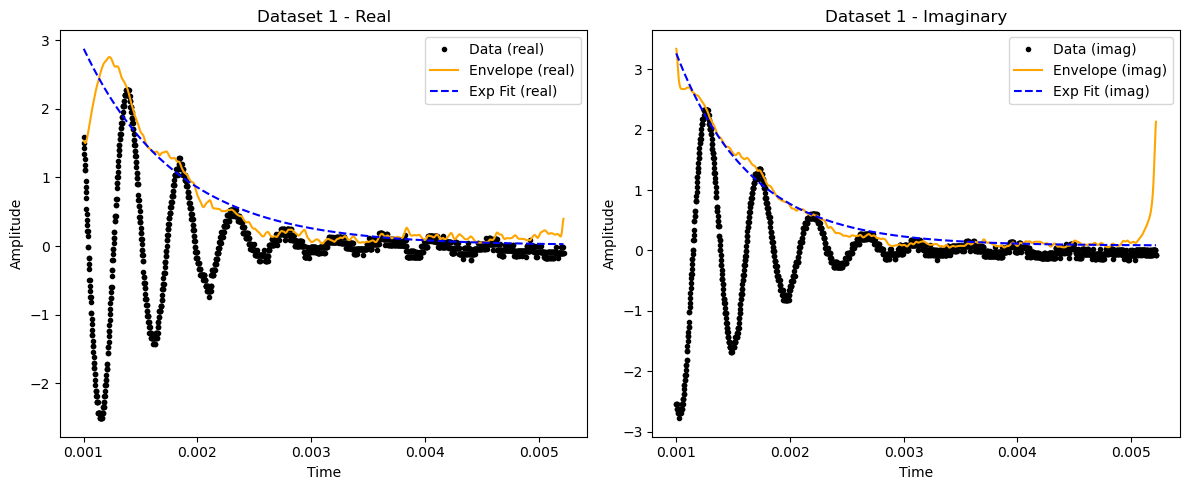

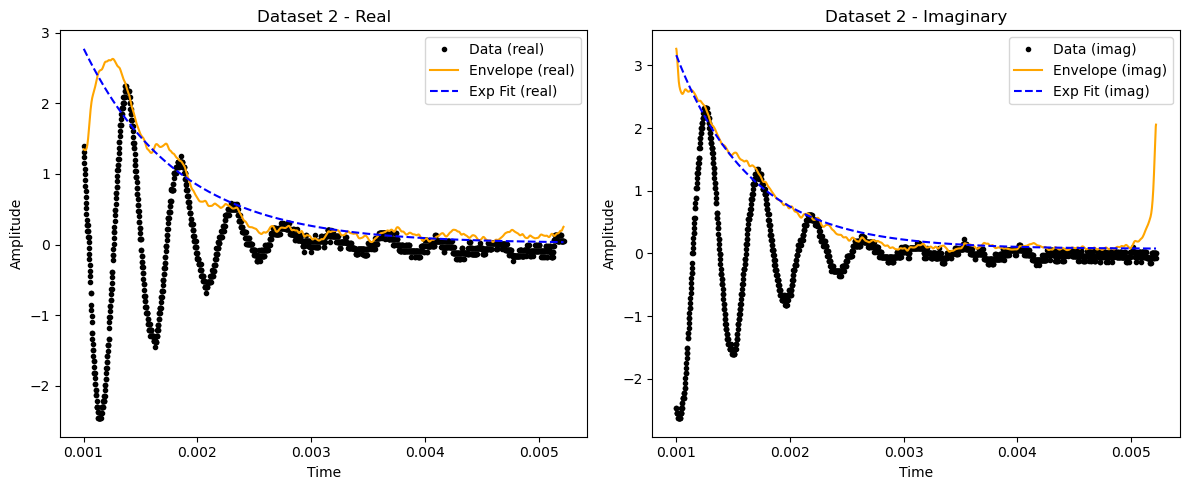

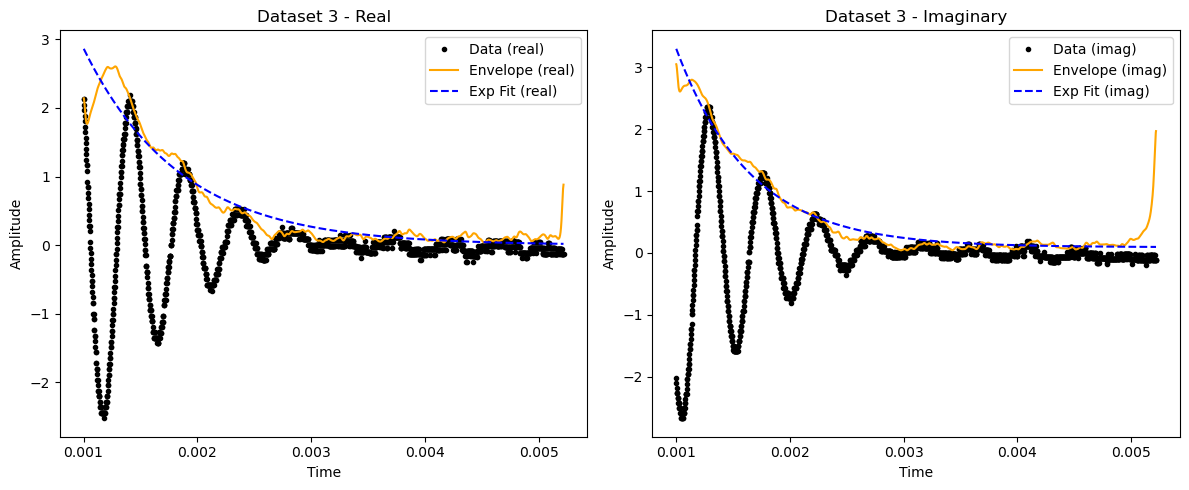

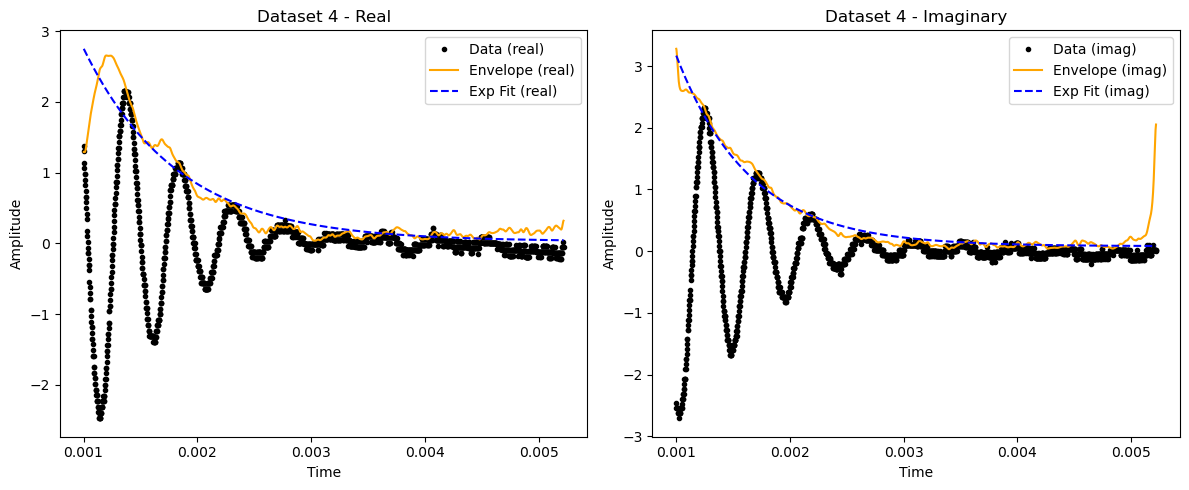

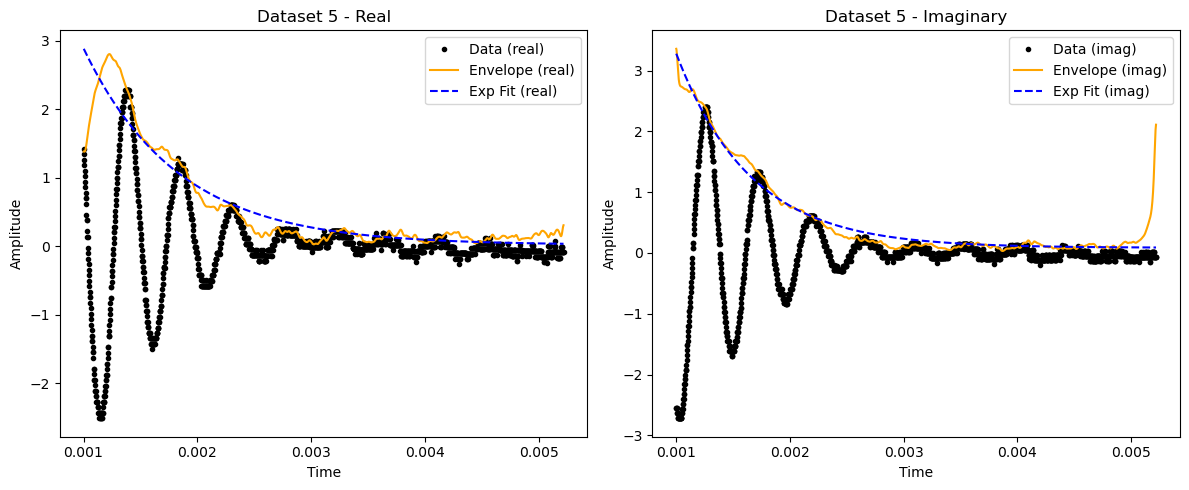

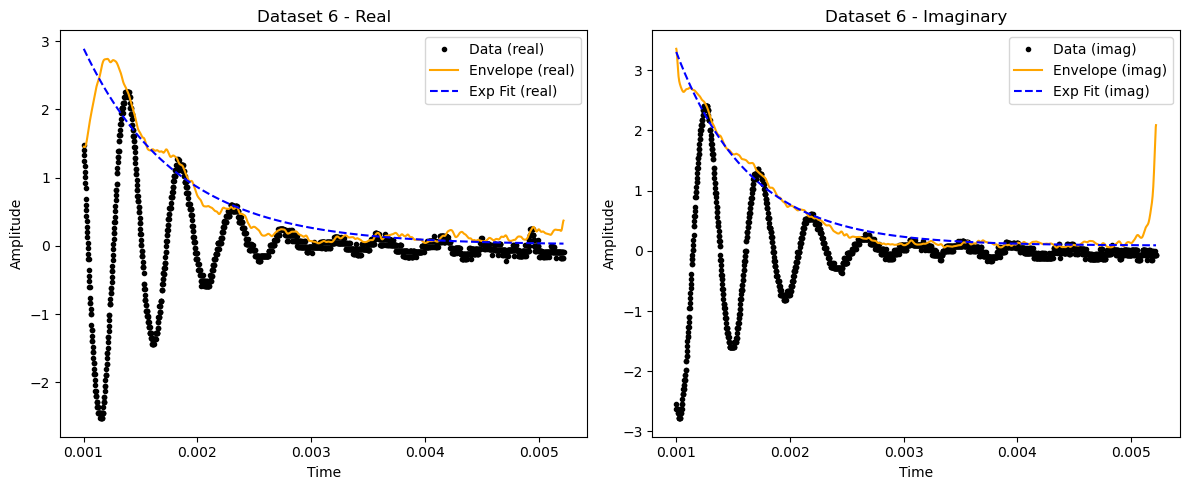

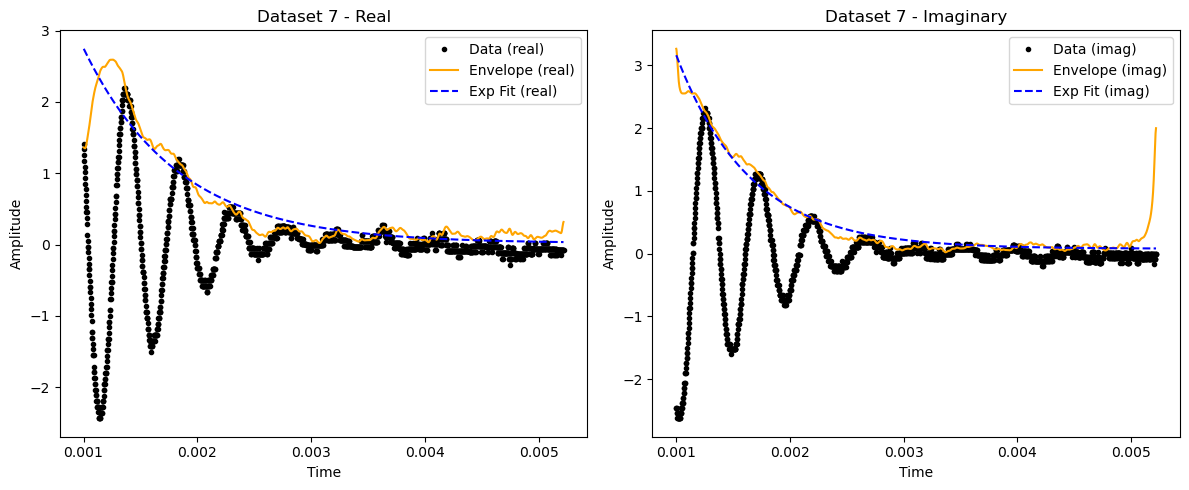

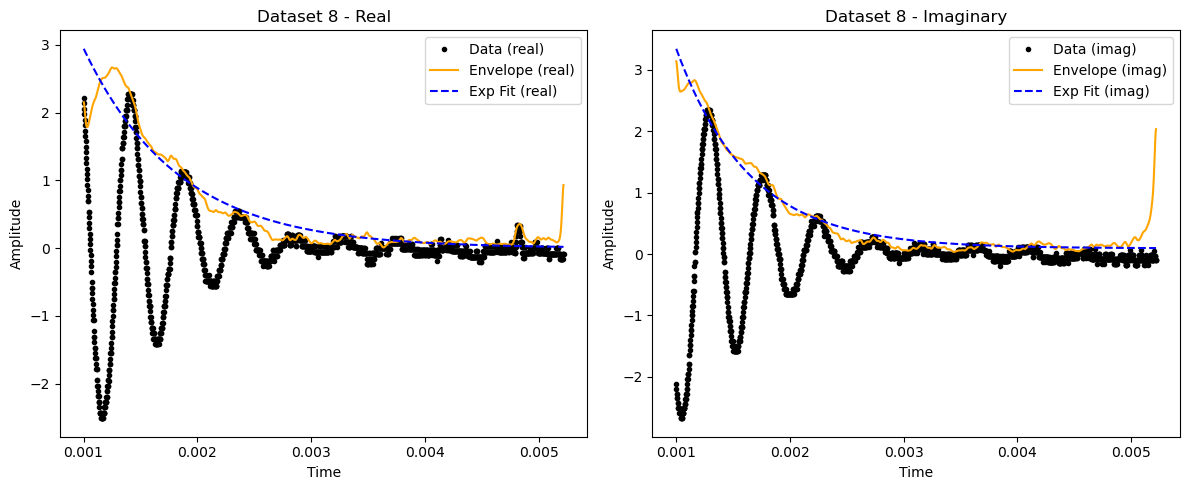

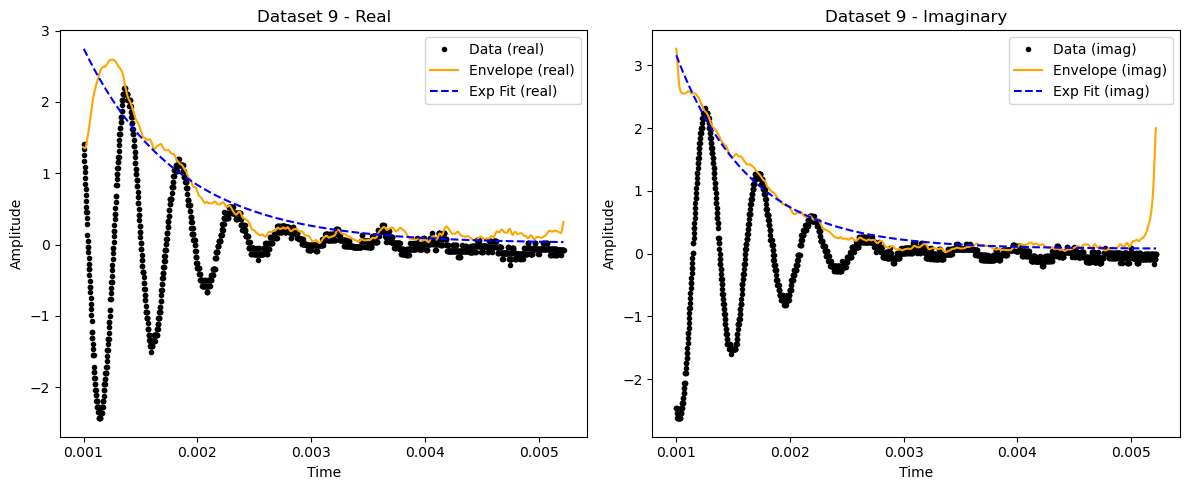

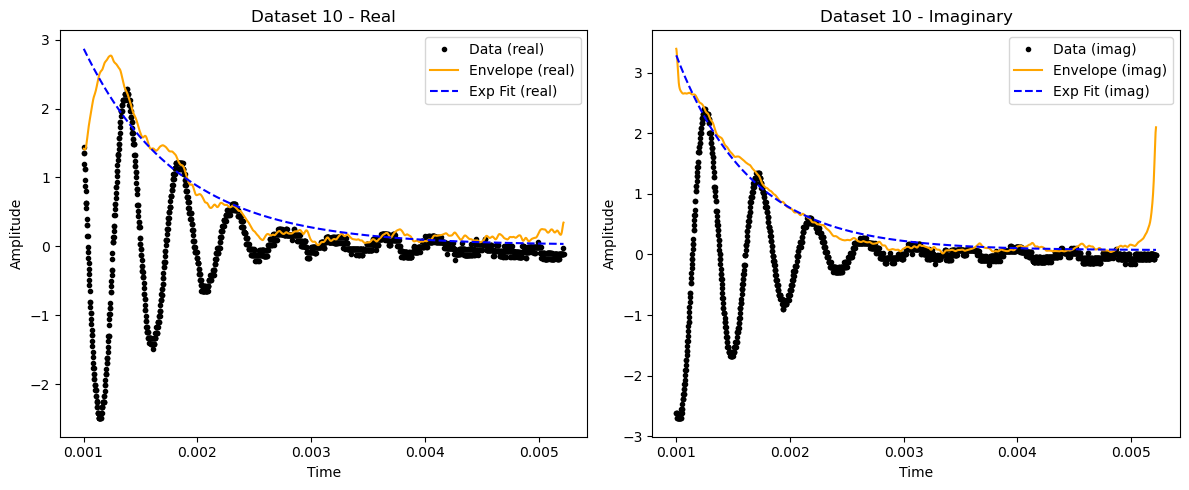

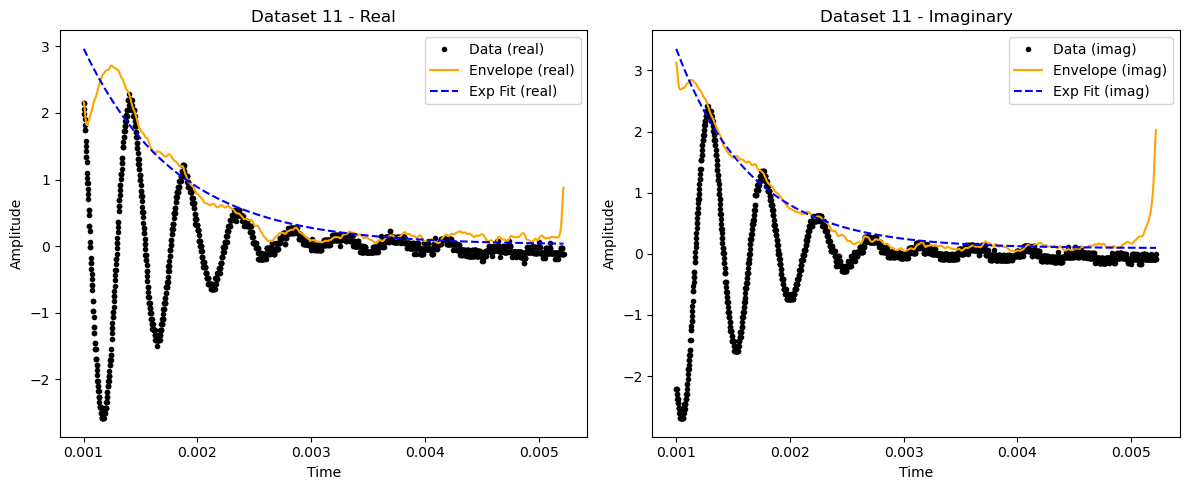

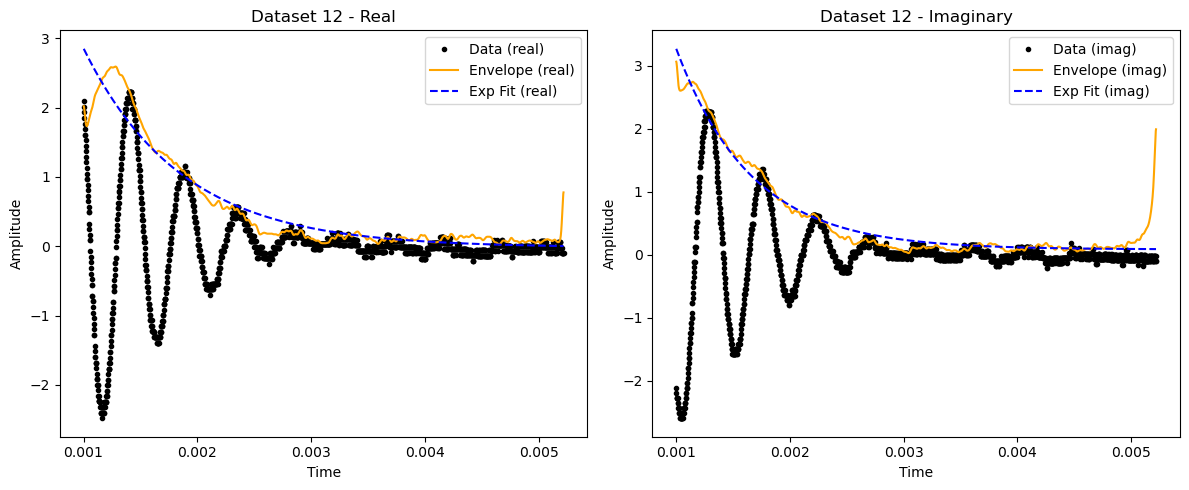

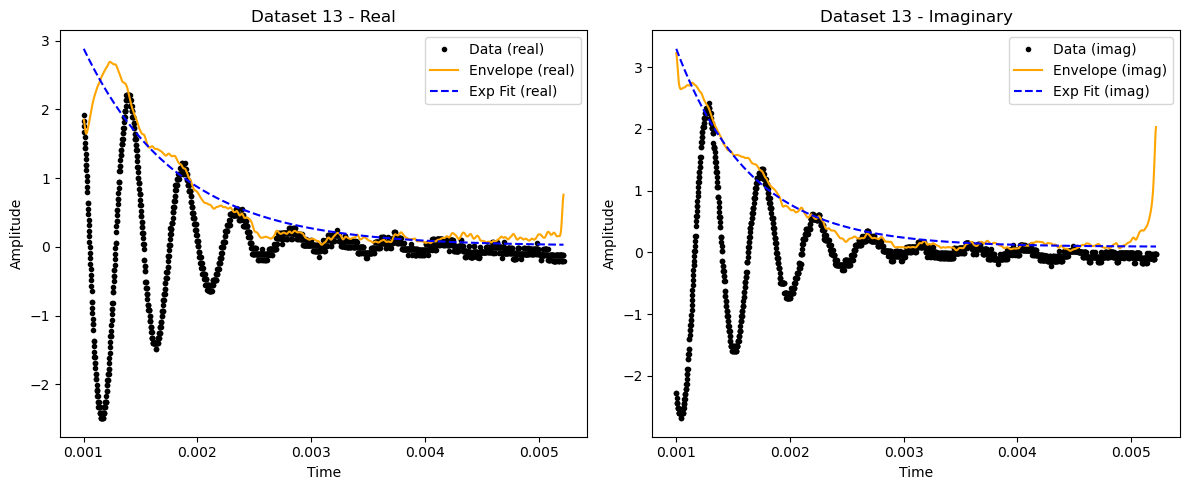

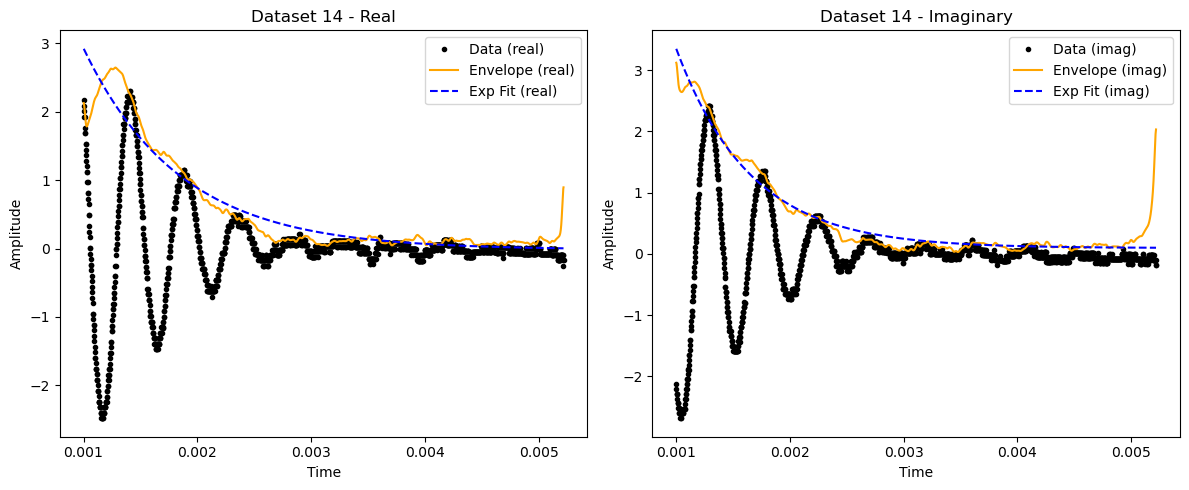

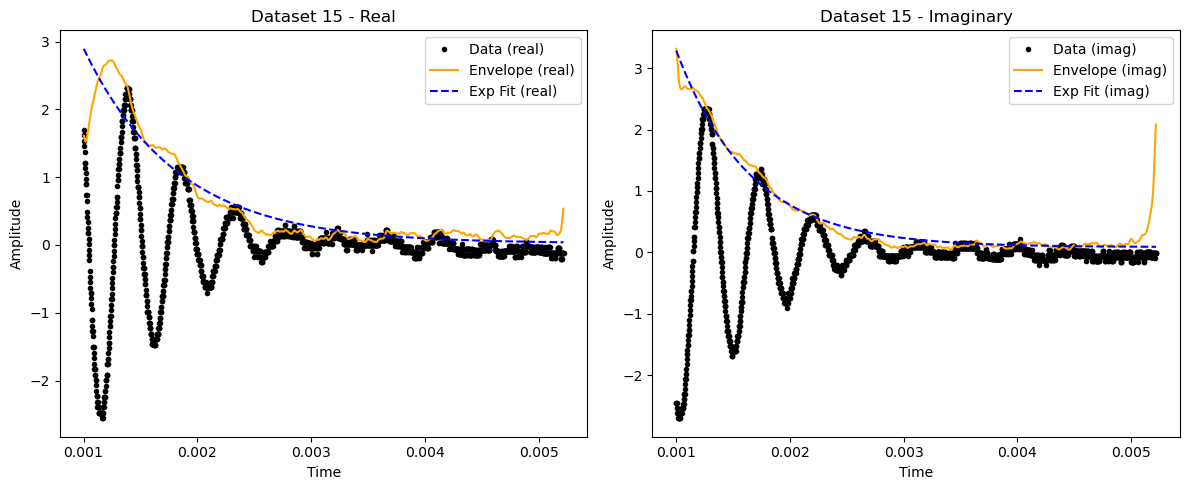

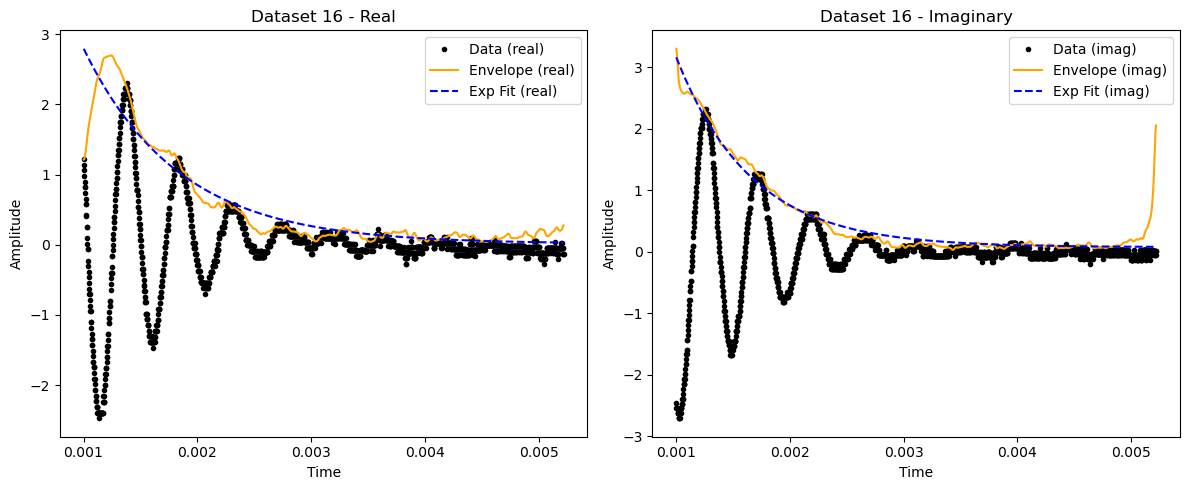

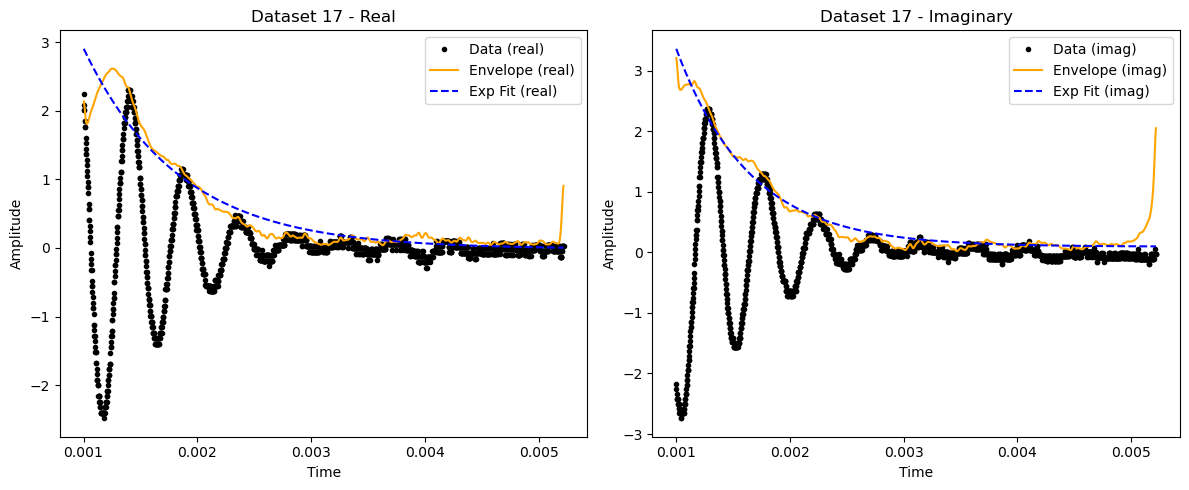

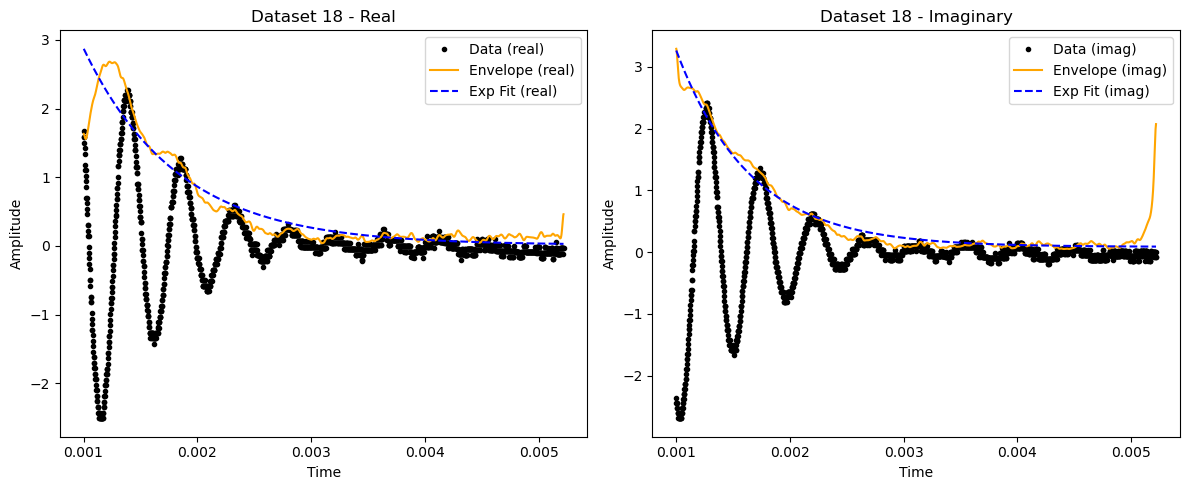

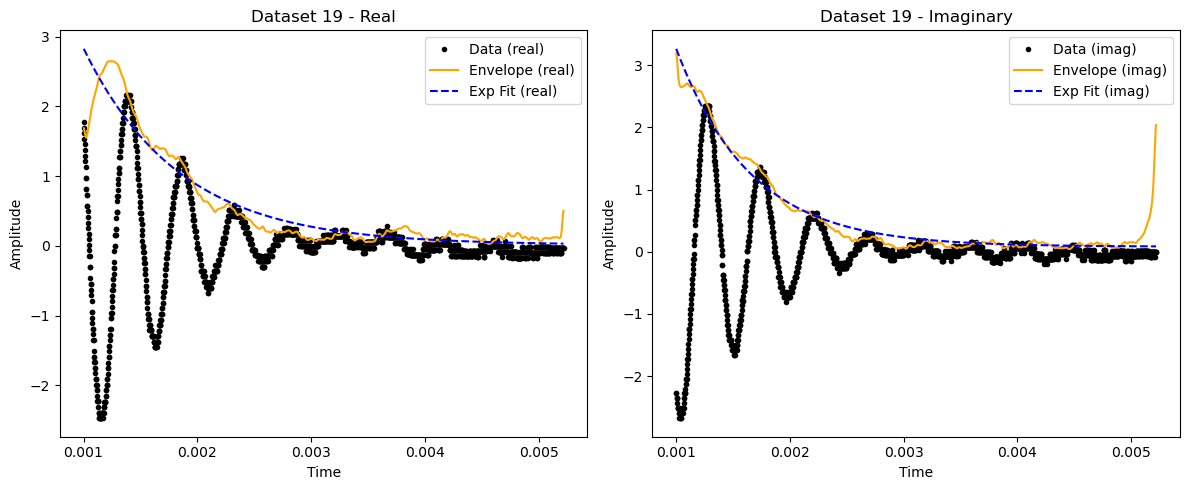

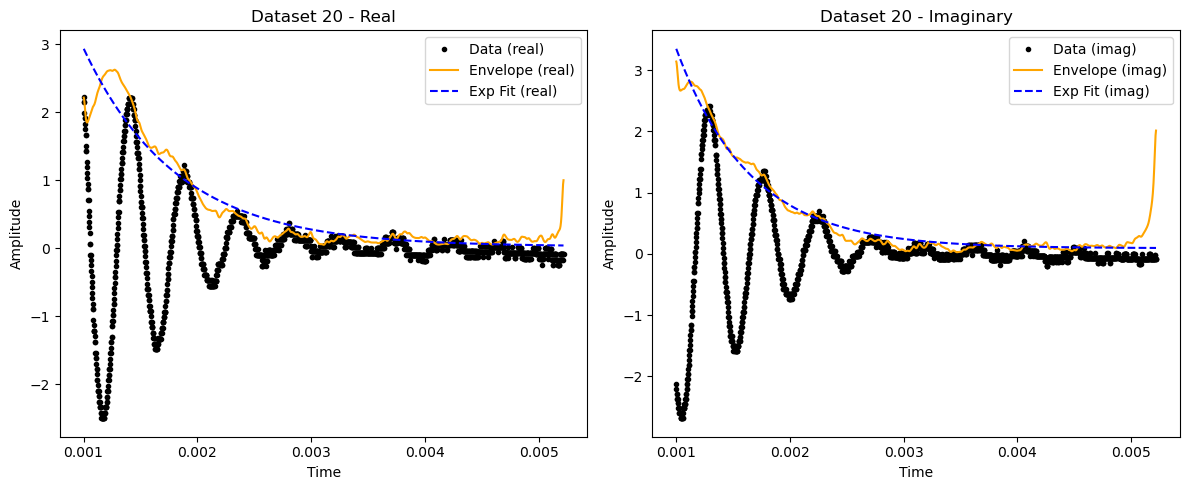

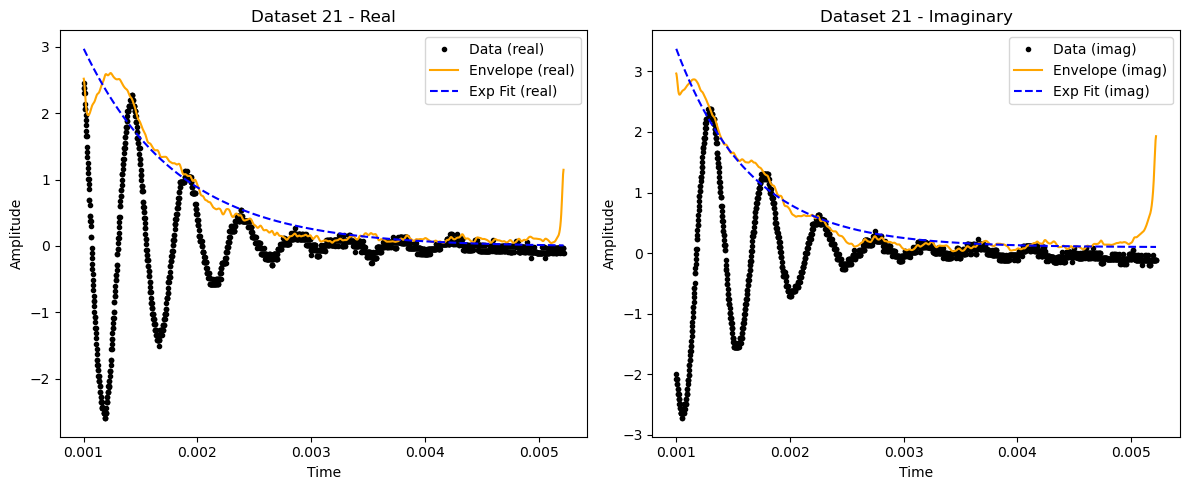

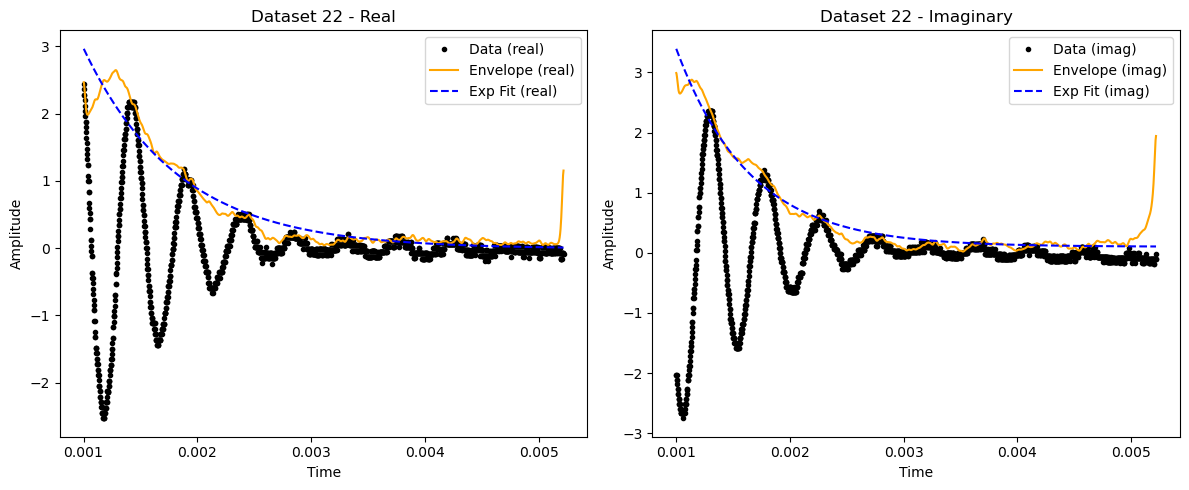

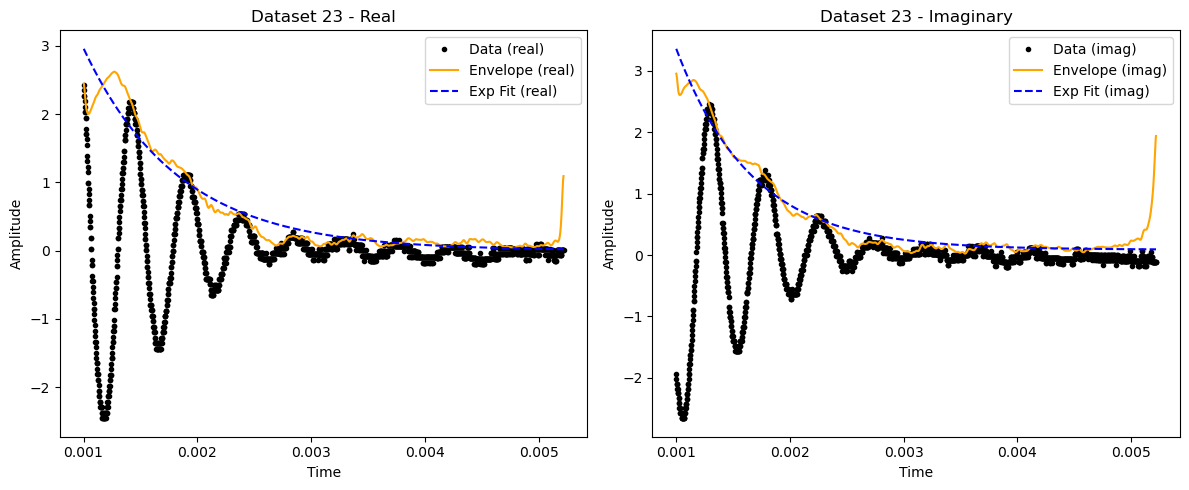

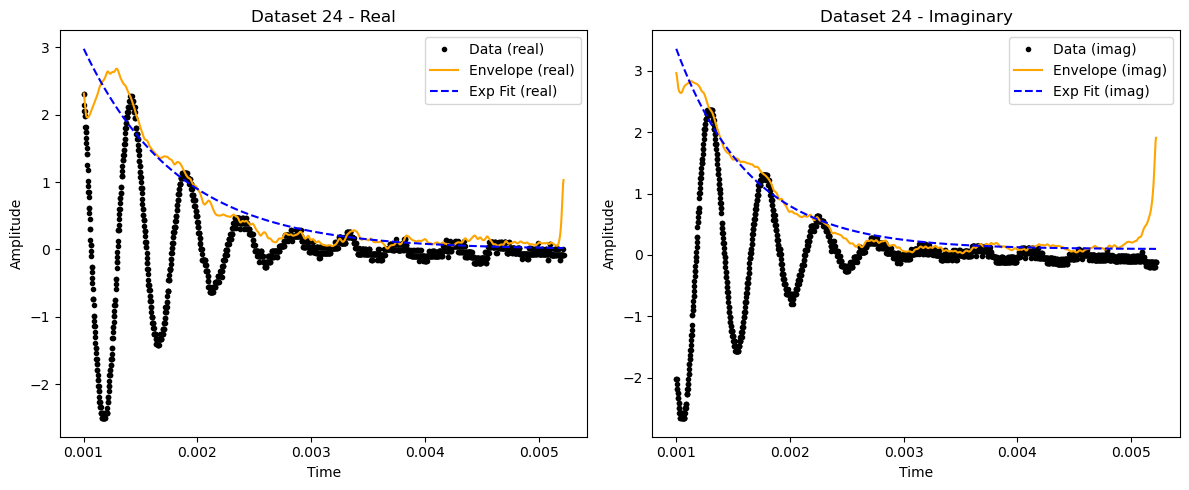

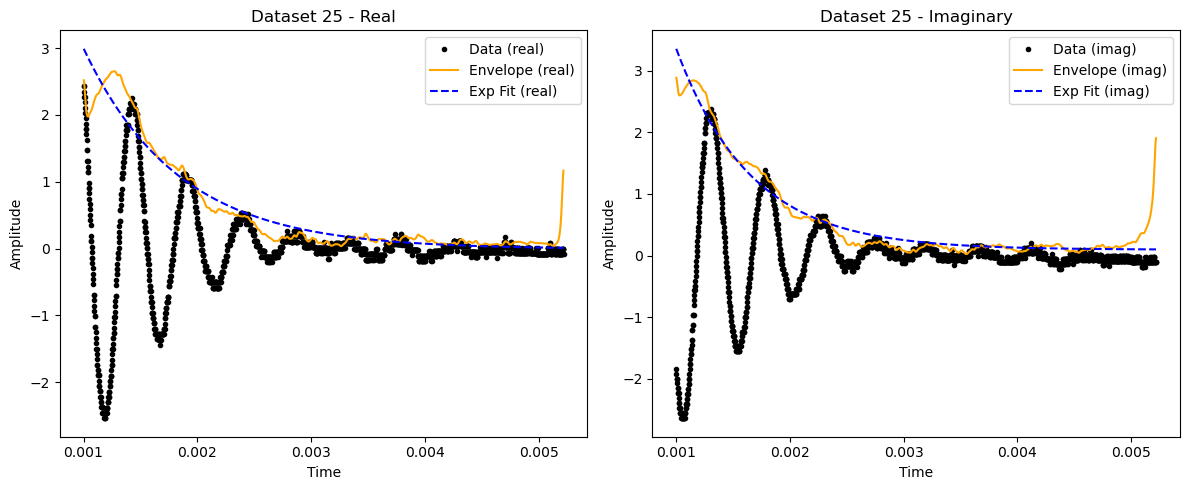

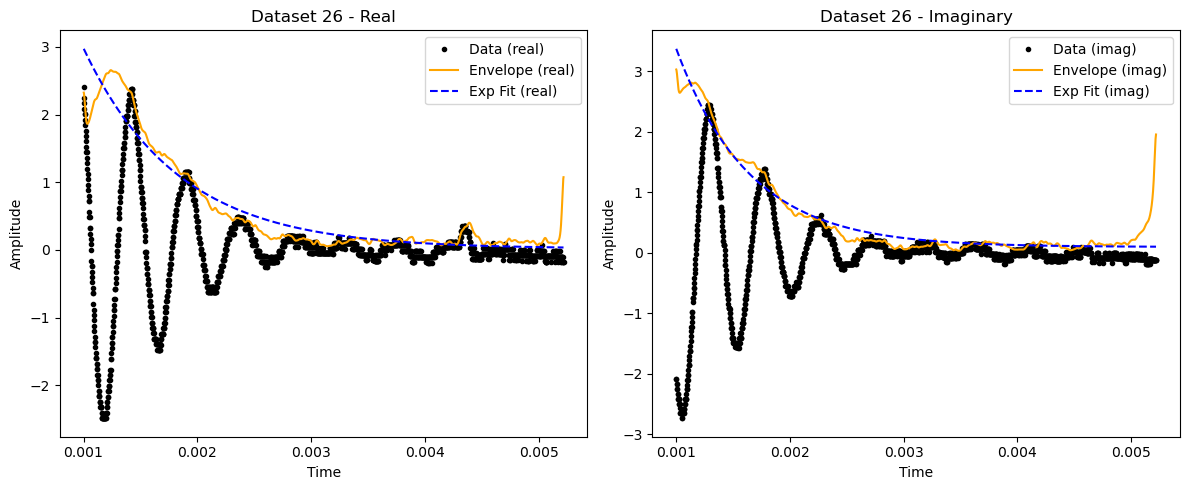

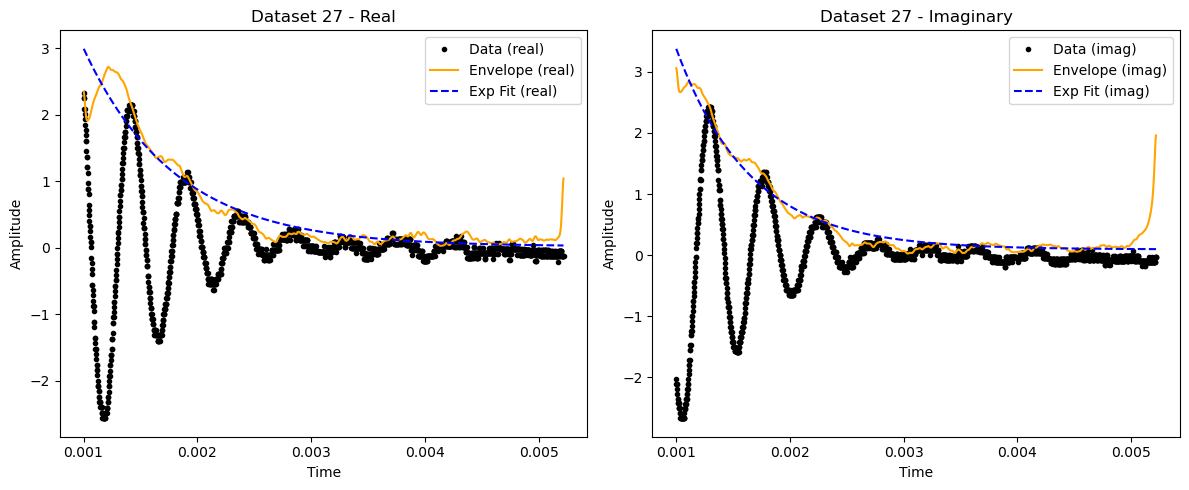

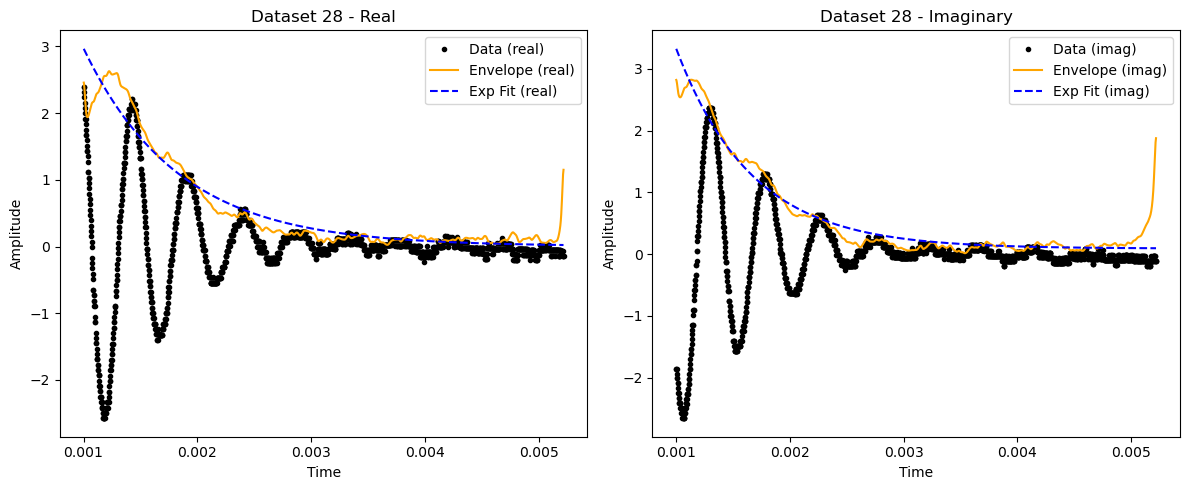

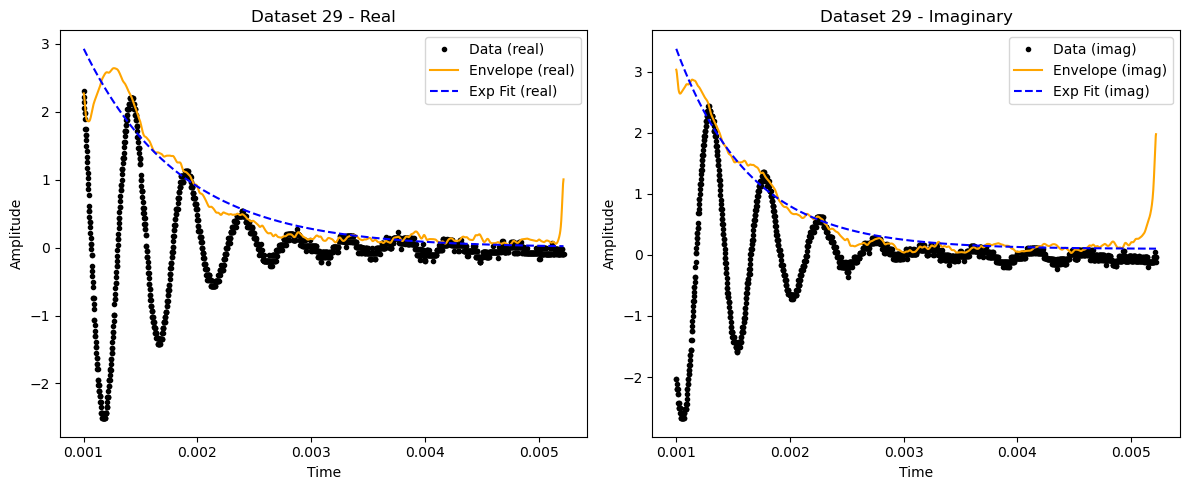

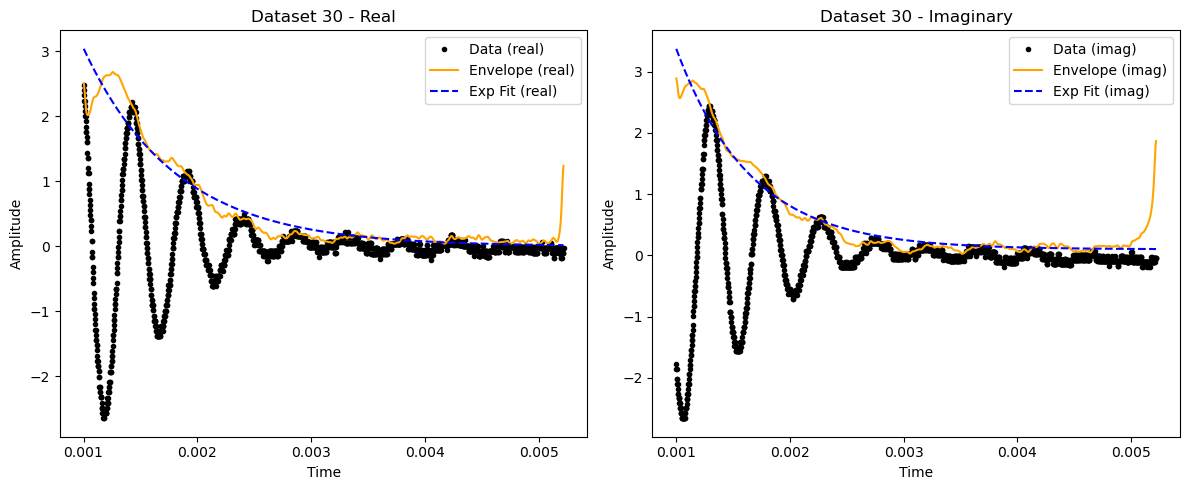

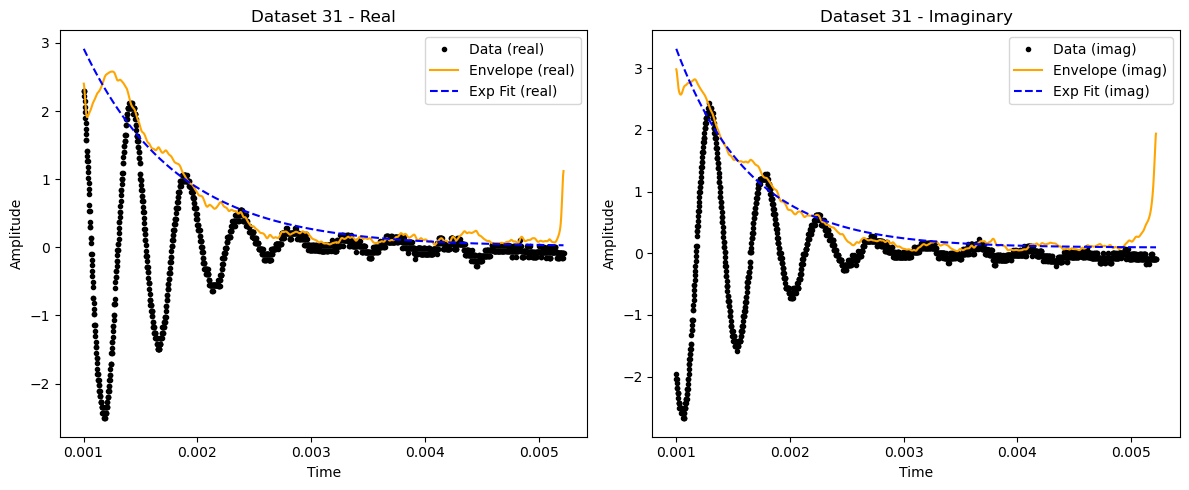

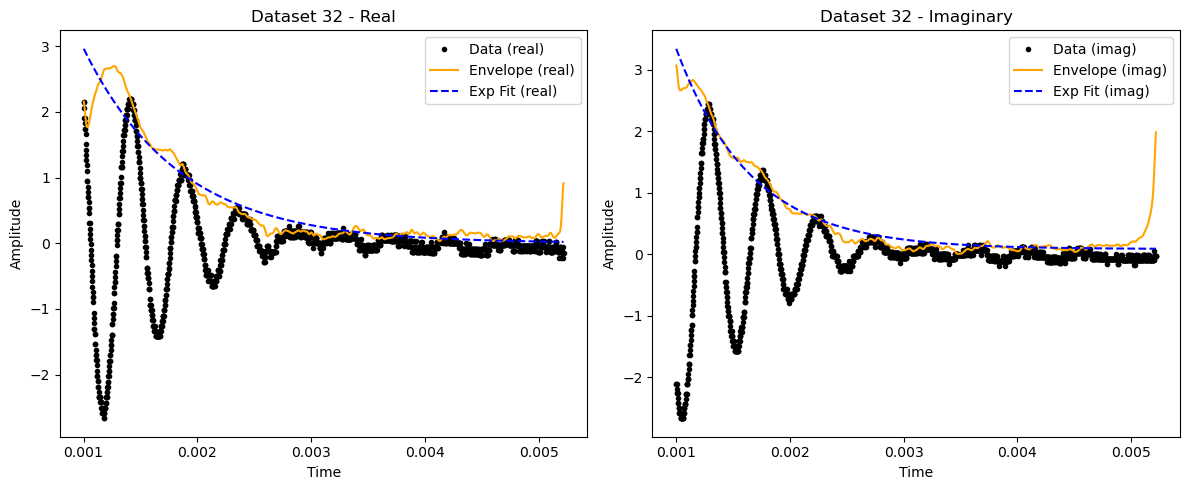

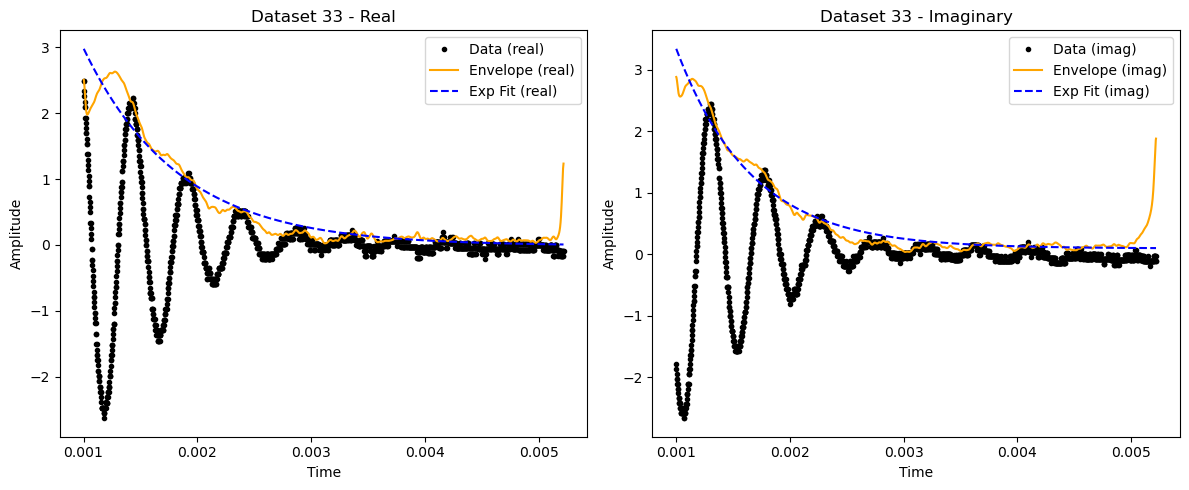

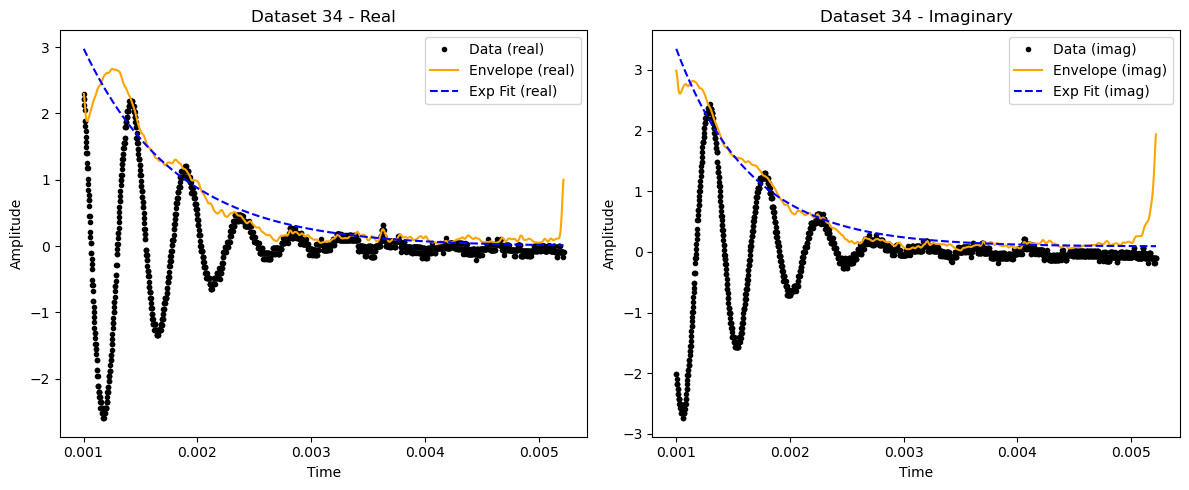

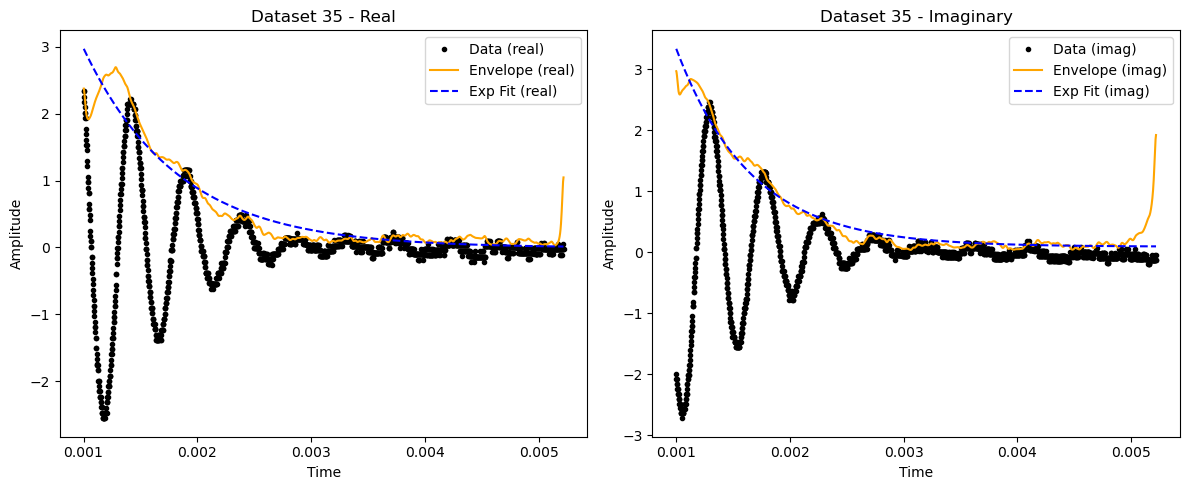

Real T2*:
  Mean T2* = 0.0008 us
  Std = 0.0000
  SEM = 0.0000
  95% CI = ±0.0000

Imaginary T2*:
  Mean T2* = 0.0007 us
  Std = 0.0000
  SEM = 0.0000
  95% CI = ±0.0000



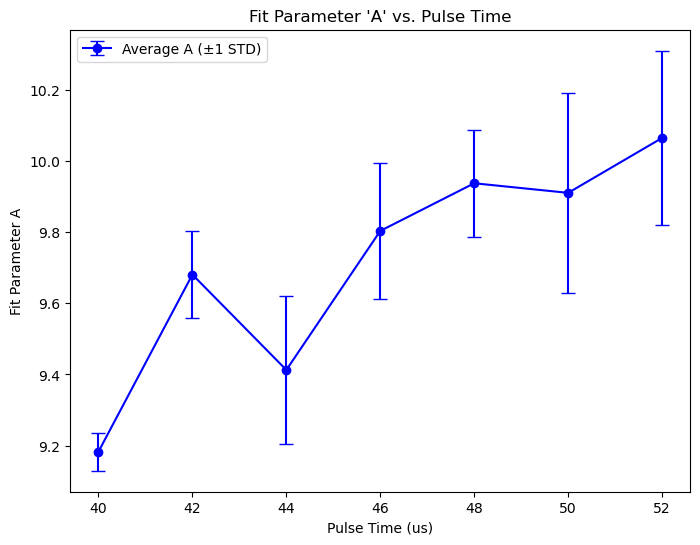

In [112]:
results = []
fits = []

# Loop through each dataset
for idx, (df, pulse_time) in enumerate(zip(data, pulse_times)):
    t = df['t'].values
    real_signal = df['CH1'].values
    imag_signal = df['CH2'].values

    # Subtract linear fit
    real_signal -= np.polyval(np.polyfit(t, real_signal, 1), t)
    imag_signal -= np.polyval(np.polyfit(t, imag_signal, 1), t)

    # Apply the robust envelope fitting to both real and imaginary channels
    popt_real, env_real = fit_decay_with_envelope(df, channel='CH1')
    popt_imag, env_imag = fit_decay_with_envelope(df, channel='CH2')
    
    # Store results (e.g., the T2* from the exponential fit)
    results.append({
        'Dataset': idx + 1,
        'Pulse Time (us)': pulse_time,
        'Real_T2star': popt_real[1],
        'Imag_T2star': popt_imag[1]
    })

    fits.append((t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag))

# Display summary results
results_df = pd.DataFrame(results)
print(results_df)

# ------------------
# PLOTTING THE FITS FOR EACH DATASET
# ------------------
# Plot the results
for idx, (t, real_signal, imag_signal, env_real, env_imag, popt_real, popt_imag) in enumerate(fits):
    # Plot Real Channel (CH1)
    plt.figure(figsize=(12, 5))

    # Real part
    plt.subplot(1, 2, 1)
    plt.plot(t, real_signal, 'k.', label='Data (real)')
    plt.plot(t, env_real, 'orange', label='Envelope (real)')
    plt.plot(t, model_exp(t, *popt_real), 'b--', label='Exp Fit (real)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Real')
    plt.legend()

    # Imaginary part
    plt.subplot(1, 2, 2)
    plt.plot(t, imag_signal, 'k.', label='Data (imag)')
    plt.plot(t, env_imag, 'orange', label='Envelope (imag)')
    plt.plot(t, model_exp(t, *popt_imag), 'b--', label='Exp Fit (imag)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'Dataset {idx+1} - Imaginary')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display summary statistics for T2* (Real and Imaginary)
def summarize(series, label):
    mean = series.mean()
    std = series.std()
    sem = std / np.sqrt(len(series))
    ci95 = 1.96 * sem
    print(f"{label}:\n  Mean T2* = {mean:.4f} us\n  Std = {std:.4f}\n  SEM = {sem:.4f}\n  95% CI = ±{ci95:.4f}\n")

# Summary for Real (CH1) and Imaginary (CH2) T2* values
real_t2star = pd.Series([popt_real[1] for _, _, _, _, _, popt_real, _ in fits])
imag_t2star = pd.Series([popt_imag[1] for _, _, _, _, _, _, popt_imag in fits])

summarize(real_t2star, "Real T2*")
summarize(imag_t2star, "Imaginary T2*")

# ------------------
# PLOTTING THE 'A' FIT PARAMETER VS. PULSE TIME
# ------------------
# Here we use the 'A' parameter from the real-part fit as the scale.
pulse_A = [popt_real[0] for (_, _, _, _, _, popt_real, _) in fits]
df_A = pd.DataFrame({'Pulse Time (us)': pulse_times, 'A': pulse_A})
grouped_A = df_A.groupby('Pulse Time (us)')['A'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(grouped_A['Pulse Time (us)'], grouped_A['mean'], yerr=grouped_A['std'],
             fmt='bo-', capsize=5, label="Average A (±1 STD)")
plt.xlabel('Pulse Time (us)')
plt.ylabel('Fit Parameter A')
plt.title("Fit Parameter 'A' vs. Pulse Time")
plt.legend()
plt.show()